### This notebook contains code to reproduce results from 'Making Markets for Information Security: The Role of Online Platforms in Bug Bounty Programs', by Johannes Wachs.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sys
import random
from scipy.stats import binom

In [2]:
#read in data on vulernabilities, researchers, and firms
hacks=pd.read_csv('hacksAnon.csv',index_col=0)
researchers=pd.read_csv('researchersAnon.csv',index_col=0)
firms = pd.read_csv('companiesParsed.csv')

### How many links do researchers make to other online platforms in their profiles?


In [3]:
[round(x,2) for x in [researchers.hasExternalLink.mean(),\
    researchers[researchers['nhacks']>1].hasExternalLink.mean(),\
        researchers[researchers['nhacks']>4].hasExternalLink.mean(),\
    researchers[researchers['nhacks']>9].hasExternalLink.mean()]]



[0.34, 0.43, 0.53, 0.6]

In [4]:
[round(x,2) for x in [researchers.hasExternalLink.mean(),\
    researchers[researchers['ndisclosedhacks']>1].hasExternalLink.mean(),\
        researchers[researchers['ndisclosedhacks']>4].hasExternalLink.mean(),\
    researchers[researchers['ndisclosedhacks']>9].hasExternalLink.mean()]]



[0.34, 0.6, 0.72, 0.8]

### Geography

In [5]:
researchers['country'].value_counts().head(10)

country
India             742
United States     505
United Kingdom    152
Russia            129
Germany           120
Canada             89
Brazil             84
Egypt              79
Pakistan           76
France             74
Name: count, dtype: int64

In [6]:
(researchers['country'].value_counts()/researchers['country'].value_counts().sum()).head(10).round(2)

country
India             0.22
United States     0.15
United Kingdom    0.04
Russia            0.04
Germany           0.04
Canada            0.03
Brazil            0.02
Egypt             0.02
Pakistan          0.02
France            0.02
Name: count, dtype: float64

### Company/firm level data. Calculate disclosure rates by firm and the rate of disclosure within the firms first k% of reports/"hacks". Write to file and run regressions in R.

In [7]:
company_to_list_of_hacks=dict(hacks.groupby('company')['database_id'].apply(list))
company_to_nhacks = {k:len(v) for k,v in company_to_list_of_hacks.items()}
companies_at_least_10_hacks = [k for k,v in company_to_nhacks.items() if v>=10]

In [8]:
firms['nhacks']=firms['companyName'].map(company_to_nhacks)

In [9]:
first_5_hacks = []
for company,list_of_hacks in company_to_list_of_hacks.items():
    first_5_hacks+=(sorted(list_of_hacks)[0:5])
    
first_10_hacks = []
for company,list_of_hacks in company_to_list_of_hacks.items():
    first_10_hacks+=(sorted(list_of_hacks)[0:10])
    
first_20_hacks = []
for company,list_of_hacks in company_to_list_of_hacks.items():
    first_20_hacks+=(sorted(list_of_hacks)[0:20])
           

first_5percentile_hacks = []
for company,list_of_hacks in company_to_list_of_hacks.items():
    fifth_percentile_order = round(len(list_of_hacks)/20)
    first_5percentile_hacks +=(sorted(list_of_hacks)[0:fifth_percentile_order])

first_10percentile_hacks = []
for company,list_of_hacks in company_to_list_of_hacks.items():
    tenth_percentile_order = round(len(list_of_hacks)/10)
    first_10percentile_hacks +=(sorted(list_of_hacks)[0:tenth_percentile_order])

first_20percentile_hacks = []
for company,list_of_hacks in company_to_list_of_hacks.items():
    twenty_percentile_order = round(len(list_of_hacks)/5)
    first_20percentile_hacks +=(sorted(list_of_hacks)[0:twenty_percentile_order])

In [10]:
hacks['in_company_first5']=hacks['database_id'].map(lambda x: 1 if x in first_5_hacks else 0)
hacks['in_company_first5pctile']=hacks['database_id'].map(lambda x: 1 if x in first_5percentile_hacks else 0)
hacks['in_company_first10']=hacks['database_id'].map(lambda x: 1 if x in first_10_hacks else 0)
hacks['in_company_first10pctile']=hacks['database_id'].map(lambda x: 1 if x in first_10percentile_hacks else 0)
hacks['in_company_first20']=hacks['database_id'].map(lambda x: 1 if x in first_20_hacks else 0)
hacks['in_company_first20pctile']=hacks['database_id'].map(lambda x: 1 if x in first_20percentile_hacks else 0)

In [11]:
hacks = hacks[hacks['company'].isin(companies_at_least_10_hacks)] #remove companies with <10 hacks 502->428
hacks = hacks[~hacks['year'].isin([2013])] #remove 2013 - 10 hacks
print(hacks['disclosure'].value_counts())
hacks=hacks[hacks['disclosure'].isin(['Undisclosed','Disclosed'])] #discard hacker published, 24 hacks
hacks['disclosed_binary'] = hacks['disclosure'].map(lambda x: 1 if x =='Disclosed' else 0)

company_to_nhacks = dict(hacks.groupby('company')['database_id'].count())
hacks['company_nhacks']=hacks['company'].map(company_to_nhacks)
hacks.to_csv('hack_level_regression_data.csv')

disclosure
Undisclosed        112910
Disclosed           10907
HackerPublished        13
Name: count, dtype: int64


### Network drawing

In [12]:
def noise_corrected(table, undirected = False, return_self_loops = False, calculate_p_value = False):
    sys.stderr.write("Calculating NC score...\n")
    table = table.copy()
    src_sum = table.groupby(by = "src").sum()[["nij"]]
    table = table.merge(src_sum, left_on = "src", right_index = True, suffixes = ("", "_src_sum"))
    trg_sum = table.groupby(by = "trg").sum()[["nij"]]
    table = table.merge(trg_sum, left_on = "trg", right_index = True, suffixes = ("", "_trg_sum"))
    table.rename(columns = {"nij_src_sum": "ni.", "nij_trg_sum": "n.j"}, inplace = True)
    table["n.."] = table["nij"].sum()
    table["mean_prior_probability"] = ((table["ni."] * table["n.j"]) / table["n.."]) * (1 / table["n.."])
    if calculate_p_value:
        table["score"] = binom.cdf(table["nij"], table["n.."], table["mean_prior_probability"])
        return table[["src", "trg", "nij", "score"]]
    table["kappa"] = table["n.."] / (table["ni."] * table["n.j"])
    table["score"] = ((table["kappa"] * table["nij"]) - 1) / ((table["kappa"] * table["nij"]) + 1)
    table["var_prior_probability"] = (1 / (table["n.."] ** 2)) * (table["ni."] * table["n.j"] * (table["n.."] - table["ni."]) * (table["n.."] - table["n.j"])) / ((table["n.."] ** 2) * ((table["n.."] - 1)))
    table["alpha_prior"] = (((table["mean_prior_probability"] ** 2) / table["var_prior_probability"]) * (1 - table["mean_prior_probability"])) - table["mean_prior_probability"]
    table["beta_prior"] = (table["mean_prior_probability"] / table["var_prior_probability"]) * (1 - (table["mean_prior_probability"] ** 2)) - (1 - table["mean_prior_probability"])
    table["alpha_post"] = table["alpha_prior"] + table["nij"]
    table["beta_post"] = table["n.."] - table["nij"] + table["beta_prior"]
    table["expected_pij"] = table["alpha_post"] / (table["alpha_post"] + table["beta_post"])
    table["variance_nij"] = table["expected_pij"] * (1 - table["expected_pij"]) * table["n.."]
    table["d"] = (1.0 / (table["ni."] * table["n.j"])) - (table["n.."] * ((table["ni."] + table["n.j"]) / ((table["ni."] * table["n.j"]) ** 2)))
    table["variance_cij"] = table["variance_nij"] * (((2 * (table["kappa"] + (table["nij"] * table["d"]))) / (((table["kappa"] * table["nij"]) + 1) ** 2)) ** 2) 
    table["sdev_cij"] = table["variance_cij"] ** .5
    if not return_self_loops:
        table = table[table["src"] != table["trg"]]
    if undirected:
        table = table[table["src"] <= table["trg"]]
    return table[["src", "trg", "nij", "score", "sdev_cij"]]


def thresholding(table, threshold):
    """Reads a preprocessed edge table and returns only the edges supassing a significance threshold.

    Args:
    table (pandas.DataFrame): The edge table.
    threshold (float): The minimum significance to include the edge in the backbone.

    Returns:
    The network backbone.
    """
    table = table.copy()
    if "sdev_cij" in table:
        return table[(table["score"] - (threshold * table["sdev_cij"])) > 0][["src", "trg", "nij", "score"]]
    else:
        return table[table["score"] > threshold][["src", "trg", "nij", "score"]]
       
    
def noise_corrected_backbone(G,threshold):
    el_table=pd.DataFrame([[x[0],x[1],x[2]['weight']] for x in G.edges(data=True)],columns=['src','trg','nij'])
    nc_table = noise_corrected(el_table,undirected=True)
    nc_backbone = thresholding(nc_table, threshold)
    F=nx.Graph()
    F.add_weighted_edges_from(nc_backbone[['src','trg','nij']].values)
    return F


In [13]:
hacker_counts = dict(hacks[hacks['year']==2020].groupby('hacker')['database_id'].nunique())
company_counts = dict(hacks[hacks['year']==2020].groupby('company')['database_id'].nunique())

In [14]:
G=nx.Graph()
wel=hacks[hacks['year']==2020].groupby(['company','hacker'])['database_id'].count().reset_index().values
G.add_weighted_edges_from(wel)
G.remove_nodes_from([x for x in hacker_counts if hacker_counts[x]<2])
G.remove_nodes_from([x for x in company_counts if company_counts[x]<10])
PP=nx.bipartite.weighted_projected_graph(G,[x for x in G if x in hacks.company.unique()])

In [15]:
bb =noise_corrected_backbone(PP,threshold=35)

Calculating NC score...


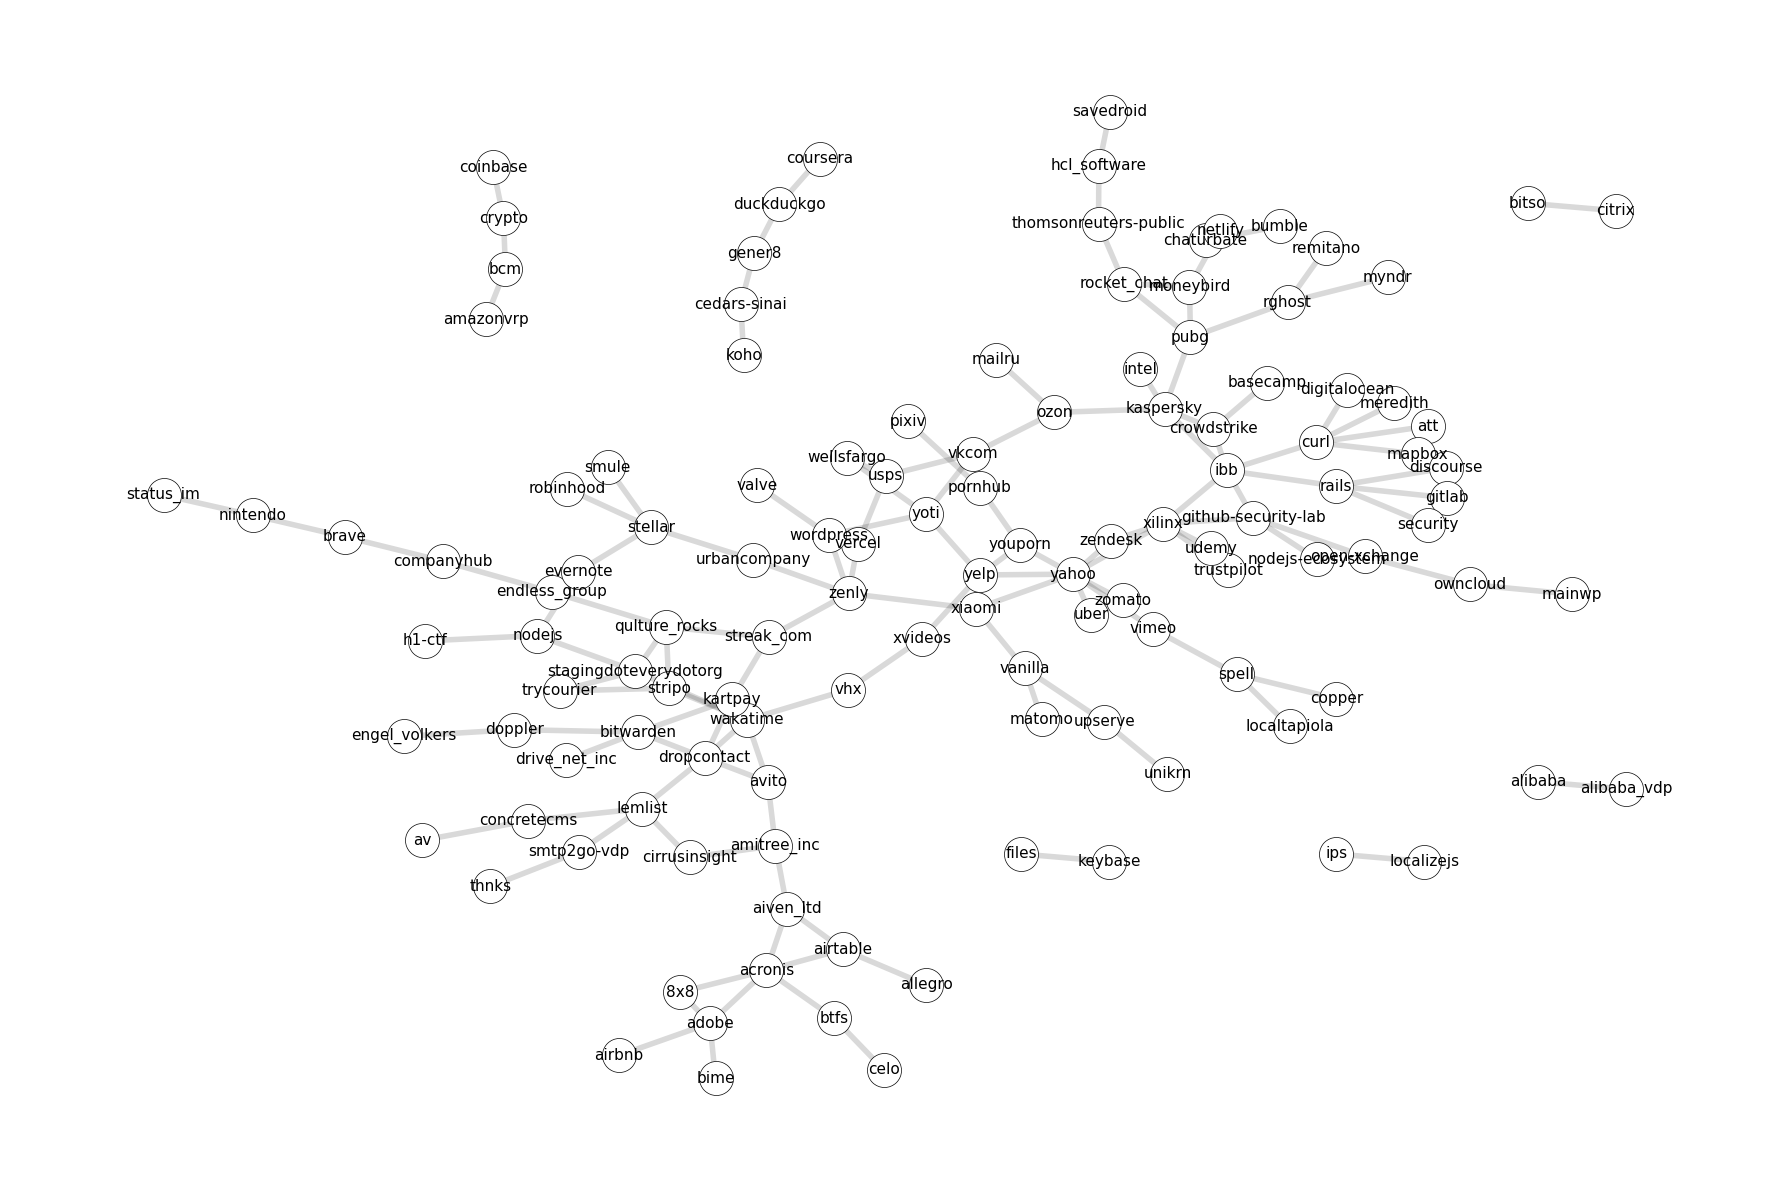

In [16]:
f,ax=plt.subplots(figsize=(18,12))

pos = nx.drawing.nx_agraph.graphviz_layout(bb,prog='neato')
pos['chaturbate']=(890.1,1200.1)
pos['bumble']=(950.1,1220.1)

nx.draw_networkx_edges(bb,pos=pos,edge_color='black',width=4,alpha=.15)
nx.draw_networkx_nodes(bb, pos, node_size=600,node_color='white',
                           linewidths=.5, alpha=1,edgecolors='black')

nx.draw_networkx_labels(bb,
                        pos=pos,font_size=11,font_color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig('net.pdf')

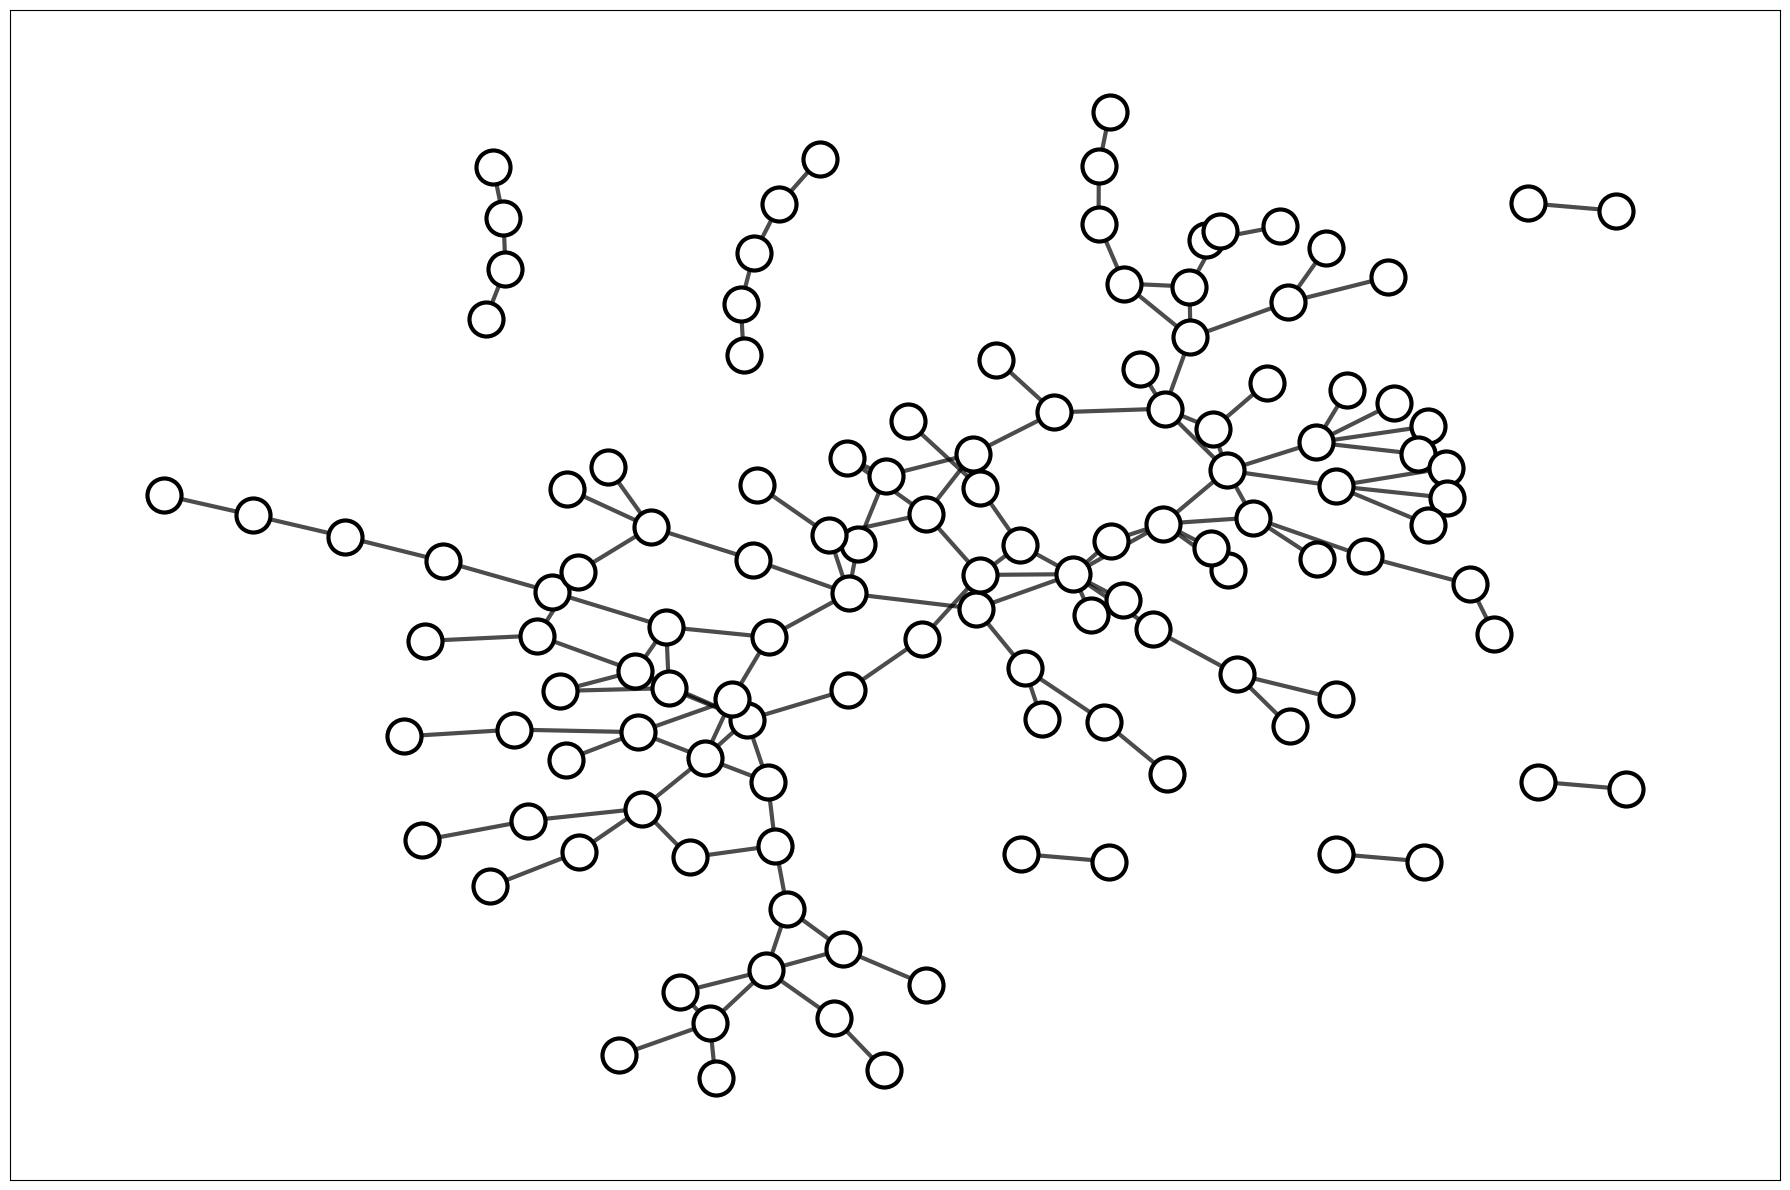

In [17]:
f,ax=plt.subplots(figsize=(18,12))

pos = nx.drawing.nx_agraph.graphviz_layout(bb,prog='neato')
pos['chaturbate']=(890.1,1200.1)
pos['bumble']=(950.1,1220.1)
pos['mainwp']=(pos['owncloud'][0]+20,pos['owncloud'][1]-70)

nx.draw_networkx_edges(bb,pos=pos,edge_color='black',width=3,alpha=.7)
nx.draw_networkx_nodes(bb, pos, node_size=600,node_color='white',
                           linewidths=3, alpha=1,edgecolors='black')


plt.tight_layout()
plt.savefig('nolabelnet.pdf')

# Embeddedness

In [18]:
estimate =[]
error = []
for y in range(2014,2022):
    year_frame=hacks[hacks['year']==y]
    #print(y,len(year_frame))
    nhacks_per_hacker = dict(year_frame.hacker.value_counts())
    year_frame['nhacksh'] = year_frame['hacker'].map(nhacks_per_hacker)
    year_frame=year_frame[(year_frame['nhacksh']>=2)]
    hackers = {k:[] for k in list(year_frame.hacker)}
    G= nx.Graph()
    G.add_weighted_edges_from(
        year_frame.groupby(['company','hacker'])['database_id'].count().reset_index().values)
    degrees=nx.degree(G)
    strengths = nx.degree(G,weight='weight')
    s_to_d = []
    for node in G.nodes():
        if node in hackers:
            s_to_d.append(strengths[node]/degrees[node])
    bs_s_to_d_mean=[]
    for _ in range(100):
        bs_s_to_d_mean.append(np.mean(random.choices(s_to_d,k=len(s_to_d))))
    estimate.append(np.mean(s_to_d))
    error.append(estimate[-1] - pd.Series(bs_s_to_d_mean).quantile(.025))
    print(y,round(np.mean(s_to_d),1),
          round(pd.Series(bs_s_to_d_mean).quantile(.025),1),
            round(pd.Series(bs_s_to_d_mean).quantile(.975),1))

/var/folders/gf/x21_n30n2l13jz3jhcfzjc_40000gn/T/ipykernel_25462/1000309998.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_frame['nhacksh'] = year_frame['hacker'].map(nhacks_per_hacker)
/var/folders/gf/x21_n30n2l13jz3jhcfzjc_40000gn/T/ipykernel_25462/1000309998.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_frame['nhacksh'] = year_frame['hacker'].map(nhacks_per_hacker)
/var/folders/gf/x21_n30n2l13jz3jhcfzjc_40000gn/T/ipykernel_25462/1000309998.py:7: SettingWithCopyWarning: 
A value is tr

2014 3.3 2.8 3.9
2015 2.5 2.3 2.8
2016 2.2 2.1 2.4
2017 2.8 2.6 3.0
2018 3.3 2.9 3.7
2019 3.7 3.4 4.0
2020 3.7 3.4 4.0
2021 3.9 3.6 4.2


/var/folders/gf/x21_n30n2l13jz3jhcfzjc_40000gn/T/ipykernel_25462/1000309998.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_frame['nhacksh'] = year_frame['hacker'].map(nhacks_per_hacker)


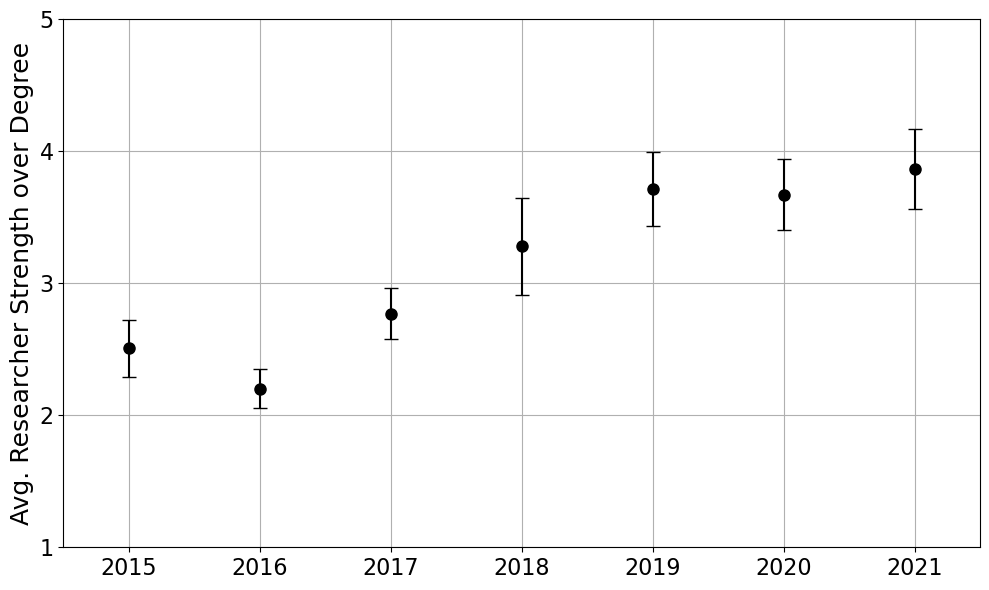

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,6))
x_ticks = (2015,2016,2017,2018,2019,2020,2021)
plt.grid()

x_1 = np.arange(1, 8)

plt.errorbar(x=x_1, y=estimate[1:], yerr=error[1:], color="black", capsize=5,
             linestyle="None",
             marker="o", markersize=8, mfc="black", mec="black")

plt.xticks(x_1, x_ticks, size=16)
plt.yticks([1,2,3,4,5],size=16)
plt.xlim([0.5,7.5])
plt.ylabel('Avg. Researcher Strength over Degree',size=18)
plt.tight_layout()
plt.savefig('strength_to_degree.pdf',dpi=300)